In [69]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [70]:
# df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
# df.set_index('LOCAL_DATE', inplace=True)

# columns_to_plot = df.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(df.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [71]:
df = pd.read_csv('collective1972-2023.csv')


In [72]:
# Drop any non-numeric columns that aren't needed for training
df.drop(['LOCAL_DATE', 'SYM', 'CITY', 'STATION', 'LATITUDE', 'LONGITUDE', 'LATITUDE', 'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST', 'COOLING_DEGREE_DAYS', 'Flow-2', 'Flow-3'], axis=1, inplace=True)

# Impute missing values
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed = df.dropna()

print(df_imputed.describe())
# Define X and Y
Y = df_imputed['Flow0']  # Target variable
X = df_imputed.drop('Flow0', axis=1)  # Features

       HEATING_DEGREE_DAYS  TOTAL_PRECIPITATION    TOTAL_RAIN    TOTAL_SNOW  \
count         22285.000000         22285.000000  22285.000000  22285.000000   
mean             13.543213             1.674898      1.107786      0.595638   
std              10.181403             3.501006      2.966420      2.165763   
min               0.000000             0.000000      0.000000      0.000000   
25%               5.200000             0.000000      0.000000      0.000000   
50%              12.500000             0.000000      0.000000      0.000000   
75%              19.100000             1.800000      0.500000      0.000000   
max              57.500000            48.000000     42.600000     48.000000   

       SNOW_ON_GROUND  MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEMPERATURE  \
count    22285.000000     22285.000000      22285.000000     22285.000000   
mean        12.995737        10.021871          4.555782        -0.930796   
std         25.037399        11.446514         10.326127 

In [73]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.30, random_state=9)


In [74]:

# Train the SVR model
# 'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'
svr_linear = SVR(kernel='linear')
svr_linear.fit(X_train, Y_train)

# Y_pred = svm_model.predict(X_test)

# Make predictions
Y_pred_scaled = svr_linear.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_pred = np.maximum(Y_pred, 0)

Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()



C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_18052\3615950434.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Coefficient', data=coef_df, palette='viridis')


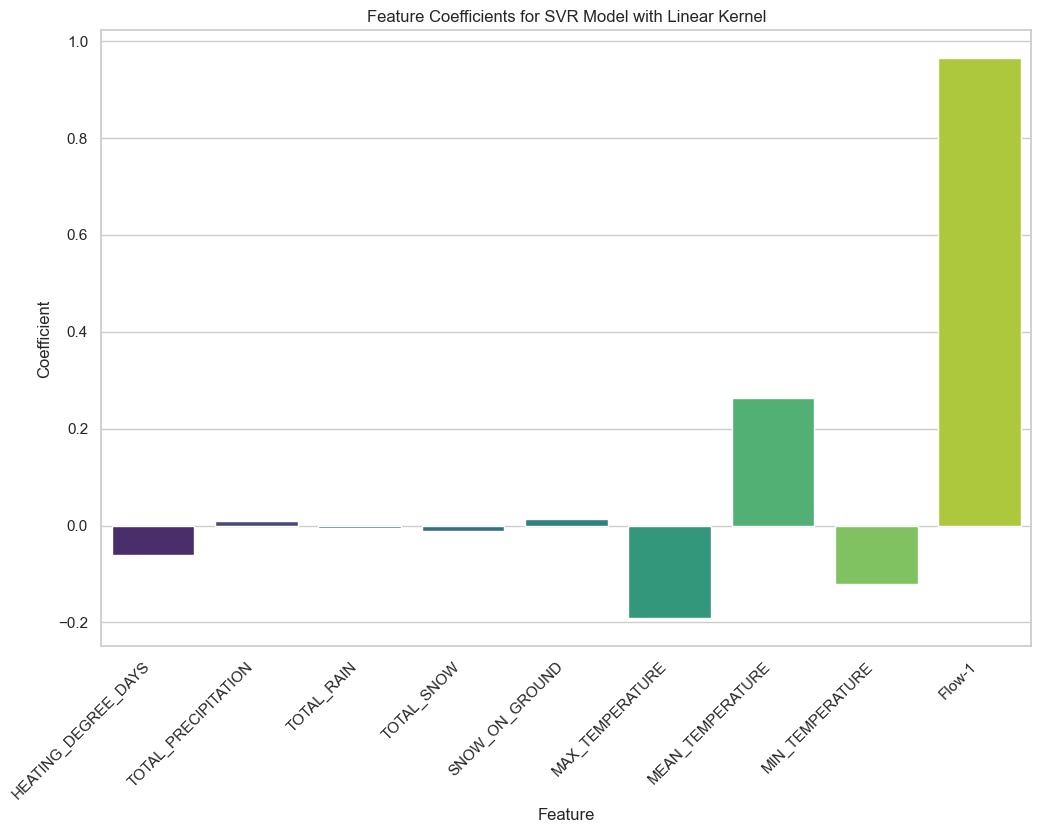

In [76]:
# Coefficients represent feature importance
feature_importance = svr_linear.coef_

coef_df = pd.DataFrame({
    'Feature': ['HEATING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'TOTAL_RAIN', 'TOTAL_SNOW', 'SNOW_ON_GROUND', 
                'MAX_TEMPERATURE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'Flow-1'],
    'Coefficient': feature_importance[0]  # For SVR with linear kernel, coef_ is a 2D array
})

# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Coefficient', data=coef_df, palette='viridis')
plt.title('Feature Coefficients for SVR Model with Linear Kernel')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:

# # Define the parameter grid
# param_grid = {
#     'kernel': ['linear'],
#     'C': [1, 10, 100, 1000],
#     'gamma': [0.01, 0.1, 1],
#     # 'epsilon': [0.01, 0.1, 1],
#     # 'degree': [2, 3, 4]  # Only for polynomial kernel
# }

# # Perform grid search
# grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, cv=2)
# grid_search.fit(X_train, Y_train)

# # Make predictions
# Y_pred_scaled = grid_search.predict(X_test)
# Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
# Y_pred = np.maximum(Y_pred, 0)

# Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# # Best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

# # Predict with best estimator
# best_svr = grid_search.best_estimator_
# Y_pred = best_svr.predict(X_test)


In [ ]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r_squared = r2_score(Y_test, Y_pred)
print(f"R-squared: {r_squared}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 6275.70394020678
R-squared: 0.9884180891856094
Root Mean Squared Error: 79.21934069535533


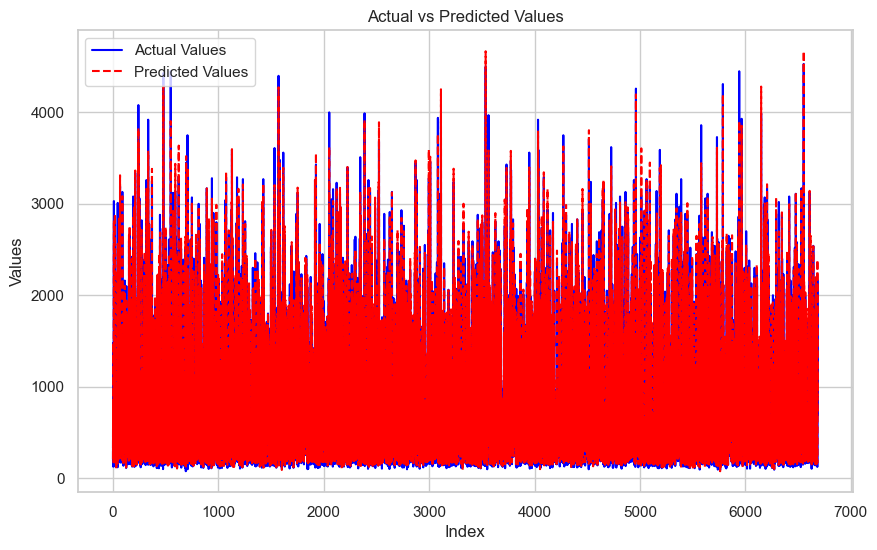

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_test)), Y_test, color='blue', label='Actual Values')
plt.plot(range(len(Y_pred)), Y_pred, color='red', linestyle='--', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

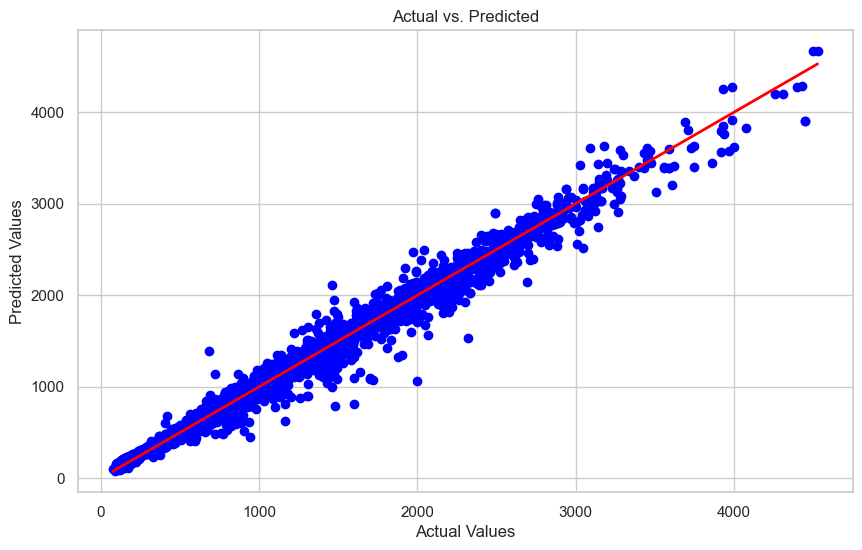

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

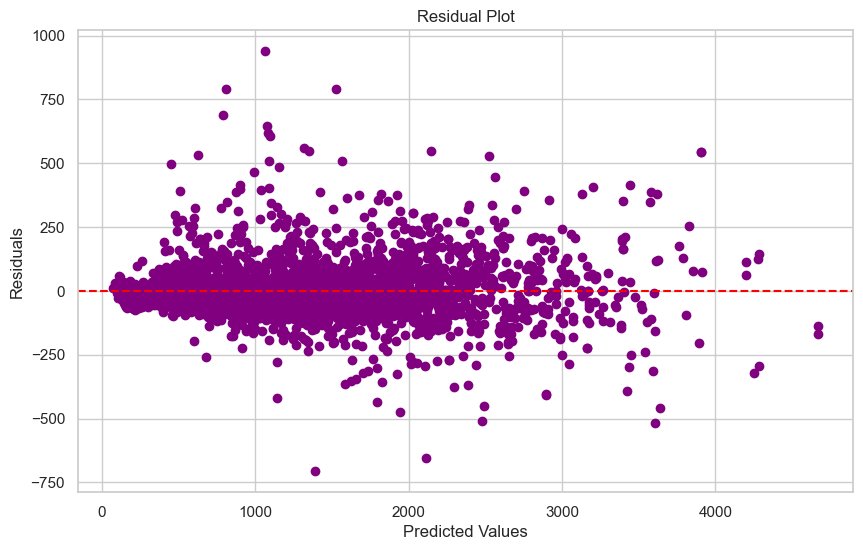

In [ ]:
residuals = Y_test - Y_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_pred, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

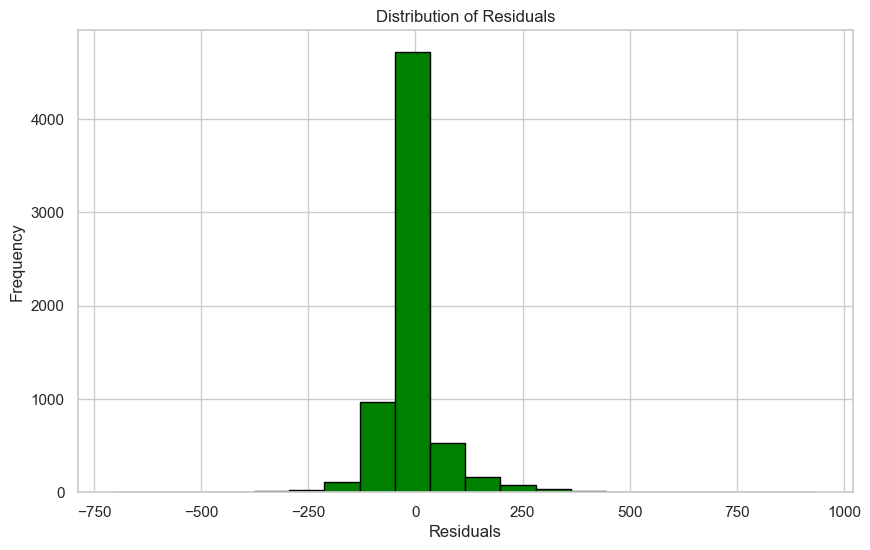

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='green', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()